In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import random_statevector, Statevector

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})

## The protocol iteration

<center><img src='img/iter.jpg'/></center>

The initial state is 

$$|\psi\rangle = c_0 |00\rangle + c_1 |01\rangle + c_2 |10\rangle + c_3 |11\rangle $$

which is shared by Alice(owns qubits 1 and 3) and Bob(owns qubits 2 and 4). There are two copies, so the total state is 

$$|\Psi\rangle  = |\psi\rangle |\psi\rangle =  (c_0 |00\rangle + c_1 |01\rangle + c_2 |10\rangle + c_3 |11\rangle) (c_0 |00\rangle + c_1 |01\rangle + c_2 |10\rangle + c_3 |11\rangle) $$

\begin{align}
|\Psi\rangle &= \color{red}{ c_{00} |0000\rangle} + c_{01} |0001\rangle + c_{02} |0010\rangle + c_{03} |0011\rangle \\
 &+ \color{red}{c_{10} |0100\rangle} + c_{11} |0101\rangle + c_{12} |0110\rangle + c_{13} |0111\rangle \\
 &+ \color{red}{c_{20} |1000\rangle} + c_{21} |1001\rangle + c_{22} |1010\rangle + c_{23} |1011\rangle \\
 &+ \color{red}{c_{30} |1100\rangle} + c_{31} |1101\rangle + c_{32} |1110\rangle + c_{33} |1111\rangle
\end{align}

This is a general 4-qubit state. At some point we require qubits 3 and 4 to be at $|0\rangle$. So,

$$|\Psi\rangle \longrightarrow c_{00}|00\rangle +  c_{10}|10\rangle + c_{20}|10\rangle +  c_{30}|11\rangle$$

Components 0,4,8,12 are saved.This state must still be normalized.

We must also take into account Qiskit's convention, the least important qubits are stored at the end, such that $|q_0q_1q_2q_3\rangle \rightarrow |q_3q_2q_1q_0\rangle$. So, when we postselect, it has to be the first two qubits at zero rather than the last two qubits.

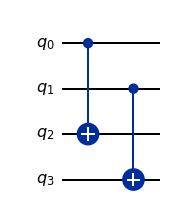

In [132]:
# Part 1 of the protocol
iter_circuit_p1 = QuantumCircuit(4)
iter_circuit_p1.cx([0,1],[2,3])

iter_circuit_p1.draw('mpl',style={'name':'iqx'})

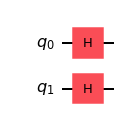

In [131]:
# Part 2 of the protocol
iter_circuit_p2 = QuantumCircuit(2)
iter_circuit_p2.h([0,1])

iter_circuit_p2.draw('mpl',style={'name':'iqx'})

In [287]:
# Function to normalize states after the measurement
def normalize_state(state):
    norm = np.sqrt(np.sum(np.abs(state)**2))
    return state/norm

# Function that takes an input state and returns the probability distribution after n iterations
def protocol_prob_distribution(sv,n_iter,qc_part1=iter_circuit_p1,qc_part2=iter_circuit_p2):
    iter_circuit_p1,iter_circuit_p2 = qc_part1,qc_part2
    
    p = np.zeros((n_iter+1,4)) # Probabilities
    p[0,:] = np.abs(sv)**2 # Initial condition
    
    for i in range(50):
        sv = normalize_state(np.array([(Statevector(np.kron(sv,sv)).evolve(iter_circuit_p1).data)[i] for i in range(4)])) # Running the first part
        sv = Statevector(sv).evolve(iter_circuit_p2) # Running the second part
        p[i+1,:] = np.abs(sv)**2 # Reading probability distribution for the (i+1)th iteration
        
    return p    

# Function for showing the initial state in the title of the plot
def display_state(state):
    r = np.abs(state)
    arg = np.angle(state)
    return ''.join([str(round(r[i],2))+'exp('+str(round(arg[i],2))+')'+r'$|$'+str(bin(i)[2:])+r'$\rangle$'+'+' for i in range(4) if r[i]!=0])


# Function for plotting the ditribution
def display_distribution(p,sv_0):
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(r'$|\psi_0\rangle = $'+display_state(sv_0)[:-1])
    axs[0, 0].plot(p[:,0],'.-')
    axs[0, 0].set_ylim([0,1])
    axs[0, 0].set_title(r'$\Pr|00\rangle$')
    axs[1, 0].plot(p[:,1],'.-')
    axs[1, 0].set_ylim([0,1])
    axs[1, 0].set_title(r'$\Pr|01\rangle$')
    axs[0, 1].plot(p[:,2],'.-')
    axs[0, 1].set_ylim([0,1])
    axs[0, 1].set_title(r'$\Pr|10\rangle$')
    axs[1, 1].plot(p[:,3],'.-')
    axs[1, 1].set_ylim([0,1])
    axs[1, 1].set_title(r'$\Pr|11\rangle$')
    fig.tight_layout()    
    

### Arbitrary input state

$$|\psi\rangle = c_0 |00\rangle + c_1 |01\rangle + c_2 |10\rangle + c_3 |11\rangle $$

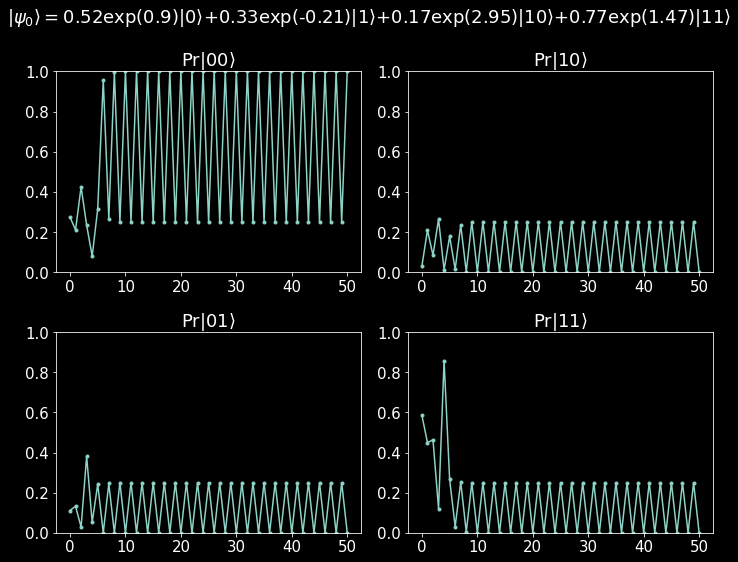

In [299]:
sv_0 = random_statevector(2**2).data # Input state

p = protocol_prob_distribution(sv_0,50)
display_distribution(p,sv_0) 

Sometimes the final state turns out to be entangled. Now, we can restrict our imputs to be of the form 

### Restricted input state

$$| \psi \rangle = \mathcal{N}(\zeta) \big( |00\rangle + \zeta |11\rangle \big)$$

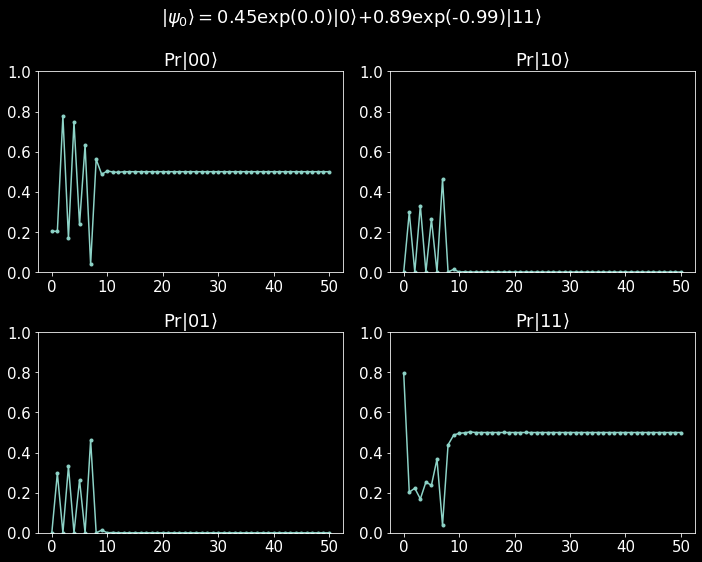

In [301]:
zeta = -2+4*np.random.rand() + -2j + 4j*np.random.rand() # Random zeta
N = 1/np.sqrt(1+np.abs(zeta)**2) # Normalization constant

sv_0 = [N,0,0,N*zeta] # Input state

p = protocol_prob_distribution(sv_0,50)
display_distribution(p,sv_0)

we distinguish between three cases 

1. The system reaches the second order fixed points $$|00\rangle \qquad \text{and} \qquad \frac{1}{2} (|00\rangle+|01\rangle+|10\rangle+|11\rangle) = |++\rangle$$
    up to relative phases.
2. The system reaches the second order fixed points $$\frac{1}{\sqrt{2}} (|00\rangle +|01\rangle) = |0+\rangle \qquad \text{and} \qquad \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle) = |+0\rangle$$
    up to relative phases.
3. The system reaches the first order fixed point $$\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$
    up to relative phases.